In [15]:
# ---- Imports ----
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap

from xgboost import XGBRegressor, plot_importance

from sklearn.metrics import classification_report, accuracy_score
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MultiLabelBinarizer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance

from skopt import BayesSearchCV
from skopt.space import Real, Integer

from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import pipeline

In [16]:
# ---- Load datasets ----

train_df = pd.read_csv('./data/train.csv')



In [17]:
# ---- Pipeline Initialization ----

class FeatureEngineer(BaseEstimator, TransformerMixin):
    def __init__(self, current_year=2024, top_n_property_types=10, top_n_amenities=50):
        self.current_year = current_year # in case data was collected in different year

        # mapping response times to numerical values
        self.response_time_mapping = {
            'within an hour': 4,
            'within a few hours': 3,
            'within a day': 2,
            'a few days or more': 1
        }

        self.top_n_property_types = top_n_property_types
        self.top_property_types = []

        # room type mapping
        self.room_type_mapping = {
            'Entire home/apt': 3,
            'Private room': 2,
            'Hotel room': 1,
            'Shared room': 0
        }

        self.top_n_amenities = top_n_amenities
        self.top_amenities = []
        self.mlb = None 

    def clean_amenities(self, amenities_series):
        return amenities_series.str.replace(r'[{}""]', '', regex=True).str.split(',').apply(
            lambda x: [i.strip() for i in x]
        )

    def fit(self, X, y=None):
        # simplify property type using regex
        property_types_simplified = X['property_type'].str.replace(
            r'^(Entire |Private |Shared |Room in )', '', regex=True
        )
        # islolate top n property types
        self.top_property_types = property_types_simplified.value_counts().nlargest(self.top_n_property_types).index.tolist()

        # Process amenities
        amenities_list = self.clean_amenities(X['amenities'].fillna(''))
        amenities = amenities_list.explode()
        self.top_amenities = amenities.value_counts().nlargest(self.top_n_amenities).index.tolist()

        # Initialize MultiLabelBinarizer with top amenities
        self.mlb = MultiLabelBinarizer(classes=self.top_amenities)
        self.mlb.fit(amenities_list.apply(lambda x: [i for i in x if i in self.top_amenities]))

        return self
    
    def transform(self, X):
        """
        Applies feature engineering transformations to the DataFrame.

        Parameters:
        - X (pd.DataFrame): The input DataFrame.

        Returns:
        - X (pd.DataFrame): The transformed DataFrame.
        """
        X = X.copy()

        # 1. Encode 'host_is_superhost' as binary
        if 'host_is_superhost' in X.columns:
            X['host_is_superhost_encoded'] = X['host_is_superhost'].astype(bool).astype(int)
        else:
            X['host_is_superhost_encoded'] = 0  # Default value if column is missing

        # 2. Ordinal encode 'host_response_time'
        if 'host_response_time' in X.columns:
            X['host_response_time_encoded'] = X['host_response_time'].map(self.response_time_mapping)
        else:
            X['host_response_time_encoded'] = self.response_time_mapping['a few days or more']  # Default value

        # 3. Encode 'room_type' as ordinal
        if 'room_type' in X.columns:
            X['room_type_encoded'] = X['room_type'].map(self.room_type_mapping)
        else:
            X['room_type_encoded'] = 0  # Default value

        # 4. Convert 'host_since' to 'host_years'
        if 'host_since' in X.columns:
            X['host_since'] = pd.to_datetime(X['host_since'], errors='coerce')
            X['host_years'] = self.current_year - X['host_since'].dt.year
            X['host_years'] = X['host_years'].fillna(0).astype(int)  # Handle NaT
        else:
            X['host_years'] = 0  # Default value

        # 5. Fill missing 'neighbourhood_group_cleansed' with 'Unknown'
        if 'neighbourhood_group_cleansed' in X.columns:
            X['neighbourhood_group_cleansed'] = X['neighbourhood_group_cleansed'].fillna('Unknown')
        else:
            X['neighbourhood_group_cleansed'] = 'Unknown'  # Default value

        # 6. Add 'has_review' feature
        if 'reviews' in X.columns:
            X['has_review'] = X['reviews'].apply(lambda x: 0 if pd.isna(x) or len(str(x).strip()) == 0 else 1)
        else:
            X['has_review'] = 0  # Default value

        # days since last review
        if 'last_review' in X.columns:
            X['last_review'] = pd.to_datetime(X['last_review'], errors='coerce')
            X['days_since_last_review'] = (pd.Timestamp.now() - X['last_review']).dt.days
            X['days_since_last_review'] = X['days_since_last_review'].fillna(0).astype(int)

        # days since first review
        if 'first_review' in X.columns:
            X['first_review'] = pd.to_datetime(X['first_review'], errors='coerce')
            X['days_since_first_review'] = (pd.Timestamp.now() - X['first_review']).dt.days
            X['days_since_first_review'] = X['days_since_first_review'].fillna(0).astype(int)

        # 9. Process 'amenities' and binarize
        amenities_list = self.clean_amenities(X['amenities'].fillna(''))
        X['amenities_simplified'] = amenities_list.apply(lambda x: [i for i in x if i in self.top_amenities])

        # Binarize the amenities
        amenities_binarized = self.mlb.transform(X['amenities_simplified'])
        amenities_df = pd.DataFrame(amenities_binarized, columns=self.mlb.classes_, index=X.index)
        X = pd.concat([X, amenities_df], axis=1)

        # 7. Simplify 'property_type' by removing room type prefixes
        if 'property_type' in X.columns:
            X['property_type_simplified'] = X['property_type'].str.replace(
                r'^(Entire |Private |Shared |Room in )', '', regex=True
            )
        else:
            X['property_type_simplified'] = 'Other'  # Default value

        # 8. Group 'property_type' into top N and 'Other'
        X['property_type_grouped'] = X['property_type_simplified'].apply(
            lambda x: x if x in self.top_property_types else 'Other'
        )

        # 9. Drop original columns that have been engineered
        columns_to_drop = [
            'host_is_superhost', 'host_response_time', 'room_type',
            'host_since', 'property_type'
        ]
        X.drop(columns=[col for col in columns_to_drop if col in X.columns], inplace=True)

        return X

In [18]:
# ---- Data Preprocessing ----

# Instantiate FeatureEngineer to access top amenities after fitting
feature_engineer = FeatureEngineer()

# Fit the FeatureEngineer on the training data to get the amenity feature names
feature_engineer.fit(train_df)

# Extract amenity feature names
amenity_features = feature_engineer.mlb.classes_.tolist()

# seperate feature types
numerical_features = [
    'latitude', 'longitude', 'host_listings_count', 'host_total_listings_count',
    'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes',
    'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms',
    'accommodates', 'bathrooms', 'bedrooms', 'beds', 'availability_30', 'availability_60',
    'availability_90', 'availability_365', 'minimum_nights', 'maximum_nights',
    'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d',
    'reviews_per_month',
    'host_years',  # Newly added numerical feature
    'days_since_last_review',
    'days_since_first_review',
    'has_review'  # Move 'has_review' here since it's binary numerical
] + amenity_features  # Include amenity features

categorical_features = [
    'host_verifications', 'bathrooms_text', 
    'has_availability', 'neighbourhood_group_cleansed',
    'neighbourhood_cleansed',
    'property_type_grouped',                  # Transformed categorical feature
    'host_response_time_encoded',             # Transformed categorical feature
    'host_is_superhost_encoded',              # Transformed categorical feature
    'room_type_encoded',                      # Transformed categorical feature
    'has_review',                              # Newly added binary feature
]

# print features in train_df that are not in numerical_features or categorical_features
print(set(train_df.columns) - set(numerical_features + categorical_features))

# features in categorical and numerical features that are not in train_df
print(set(numerical_features + categorical_features) - set(train_df.columns))

# define preprocessing for numerical data
numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),  
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(
        drop='first',
        handle_unknown='infrequent_if_exist',
        min_frequency=5,  # Adjust based on your data
    ))
])

# combine preprocessing steps
preprocessor = ColumnTransformer([
    ('numerical', numerical_pipeline, numerical_features),
    ('categorical', categorical_pipeline, categorical_features)
], remainder='drop')

# create full pipeline
pipeline = Pipeline([
    ('feature_engineer', FeatureEngineer()),
    ('preprocessor', preprocessor),
    ('model', XGBRegressor(
        colsample_bytree=0.7896615860728206,
        learning_rate=0.02157373365594319,
        max_depth=8,
        n_estimators=1617,
        min_child_weight=10,
        subsample=0.6,
        eval_metric='rmse'
    ))
])

{'name', 'room_type', 'review_scores_cleanliness', 'amenities', 'review_scores_value', 'review_scores_location', 'host_response_rate', 'first_review', 'host_response_time', 'host_since', 'price', 'host_has_profile_pic', 'review_scores_communication', 'instant_bookable', 'review_scores_rating', 'review_scores_checkin', 'last_review', 'description', 'reviews', 'host_identity_verified', 'host_acceptance_rate', 'property_type', 'review_scores_accuracy', 'host_is_superhost'}
{'Carbon monoxide alarm', 'days_since_last_review', 'Lockbox', 'Body soap', 'Bathtub', 'host_is_superhost_encoded', 'Essentials', 'Shampoo', 'Toaster', 'Cleaning products', 'room_type_encoded', 'Luggage dropoff allowed', 'Dining table', 'Oven', 'Self check-in', 'Bed linens', 'Wifi]', 'Hot water', 'Laundromat nearby', 'Heating', 'host_years', 'Wifi', 'Stove', 'Pets allowed', 'host_response_time_encoded', 'First aid kit', 'Refrigerator', 'Conditioner', 'Hot water kettle', 'Room-darkening shades', 'Smoke alarm', 'Hangers',

In [20]:
# Load train data
X = train_df.drop(columns=['price'])
y = train_df['price']

# ---- Split the Data into Training and Testing Sets ----
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0
)

# ---- Fit the Pipeline on the Training Data ----
pipeline.fit(X_train, y_train)

# Define the number of folds for cross-validation
n_splits = 5  # You can adjust this number for quicker testing

# Initialize the K-Fold cross-validator
kf = KFold(n_splits=n_splits, shuffle=True, random_state=0)

# Perform cross-validation on the training data
cv_scores = cross_val_score(
    estimator=pipeline,
    X=X_train,
    y=y_train,
    scoring='neg_root_mean_squared_error',  # Use negative RMSE as scoring
    cv=kf,
    n_jobs=-1,
    verbose=1
)

# Convert scores to positive values
cv_rmse_scores = -cv_scores

# Calculate mean and standard deviation of RMSE scores
mean_cv_rmse = np.mean(cv_rmse_scores)
std_cv_rmse = np.std(cv_rmse_scores)

print(f'Cross-Validation RMSE Scores: {cv_rmse_scores}')
print(f'Mean CV RMSE: {mean_cv_rmse:.4f}')
print(f'Standard Deviation of CV RMSE: {std_cv_rmse:.4f}')

# ---- Evaluate the Model on the Test Set ----
# Predict on the test set
y_test_pred = pipeline.predict(X_test)

# Calculate RMSE on the test set
test_rmse = np.sqrt(np.mean((y_test - y_test_pred) ** 2))
print(f'Test RMSE: {test_rmse:.4f}')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 14 concurrent workers.
/Users/michaelscutari/micromamba/envs/cs671/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/michaelscutari/micromamba/envs/cs671/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [1, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    8.0s remaining:   12.0s
/Users/michaelscutari/micromamba/envs/cs671/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [1, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/michaelscutari/micromamba/envs/cs671/lib/python3.12/site-package

Cross-Validation RMSE Scores: [0.71451202 0.75460904 0.72443648 0.72808892 0.72914905]
Mean CV RMSE: 0.7302
Standard Deviation of CV RMSE: 0.0133
Test RMSE: 0.7257


/Users/michaelscutari/micromamba/envs/cs671/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [ ]:
# ---- Exporting test results ----
test_df = pd.read_csv('./data/test.csv')

# predict
y_test_pred = pipeline.predict(test_df)

# round to nearest integer
y_test_pred = np.round(y_test_pred, 0).astype(int)

# save to csv
test_df['price'] = y_test_pred
test_df[['id', 'price']].to_csv('./data/test_results.csv', index=False)

/Users/michaelscutari/micromamba/envs/cs671/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [21]:
# ---- Feature Importance ----
# Function to get feature names from the ColumnTransformer
def get_feature_names(column_transformer):
    feature_names = []

    # Retrieve transformer list
    for name, transformer, features in column_transformer.transformers_:
        if name != 'remainder':
            if hasattr(transformer, 'get_feature_names_out'):
                # If the transformer has get_feature_names_out, use it
                transformed_features = transformer.get_feature_names_out(features)
            else:
                # If not, use the original feature names
                transformed_features = features
            feature_names.extend(transformed_features)
        elif transformer == 'passthrough':
            # Append passthrough features
            feature_names.extend(features)
    return feature_names

# Get feature names from the preprocessor
preprocessor = pipeline.named_steps['preprocessor']
feature_names = get_feature_names(preprocessor)

# Print the total number of features after preprocessing
print(f'Total number of features: {len(feature_names)}')

Total number of features: 286


In [22]:
# Perform permutation importance on the test set
perm_importance = permutation_importance(
    pipeline,
    X_test,
    y_test,
    n_repeats=10,
    random_state=0,
    scoring='neg_root_mean_squared_error'
)

# Get the importance scores
perm_importance_mean = perm_importance.importances_mean

# Create a DataFrame for visualization
perm_importance_df = pd.DataFrame({
    'Feature': X_test.columns,
    'Importance': perm_importance_mean
})

# Sort features by importance
perm_importance_df.sort_values(by='Importance', ascending=False, inplace=True)

# Display the top 20 most important features
perm_importance_df.head(20)

/Users/michaelscutari/micromamba/envs/cs671/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/michaelscutari/micromamba/envs/cs671/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/michaelscutari/micromamba/envs/cs671/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/michaelscutari/micromamba/envs/cs671/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1, 4] during transform. These unknown categories wi

KeyboardInterrupt: 

In [ ]:
# Get the trained model from the pipeline
model = pipeline.named_steps['model']

# Retrieve feature importances from the model
importances = model.feature_importances_

# Create a DataFrame for visualization
import pandas as pd

feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort features by importance
feature_importance_df.sort_values(by='Importance', ascending=False, inplace=True)

# Display the top 20 most important features
feature_importance_df.head(20)

,Feature,Importance
283,room_type_encoded_2,0.324035
284,room_type_encoded_3,0.242142
16,minimum_nights,0.043792
271,property_type_grouped_hotel,0.030812
82,bathrooms_text_1 private bath,0.017963
8,accommodates,0.011979
71,[Dishwasher,0.010080
9,bathrooms,0.010007
99,neighbourhood_group_cleansed_Manhattan,0.008999
2,host_listings_count,0.007276


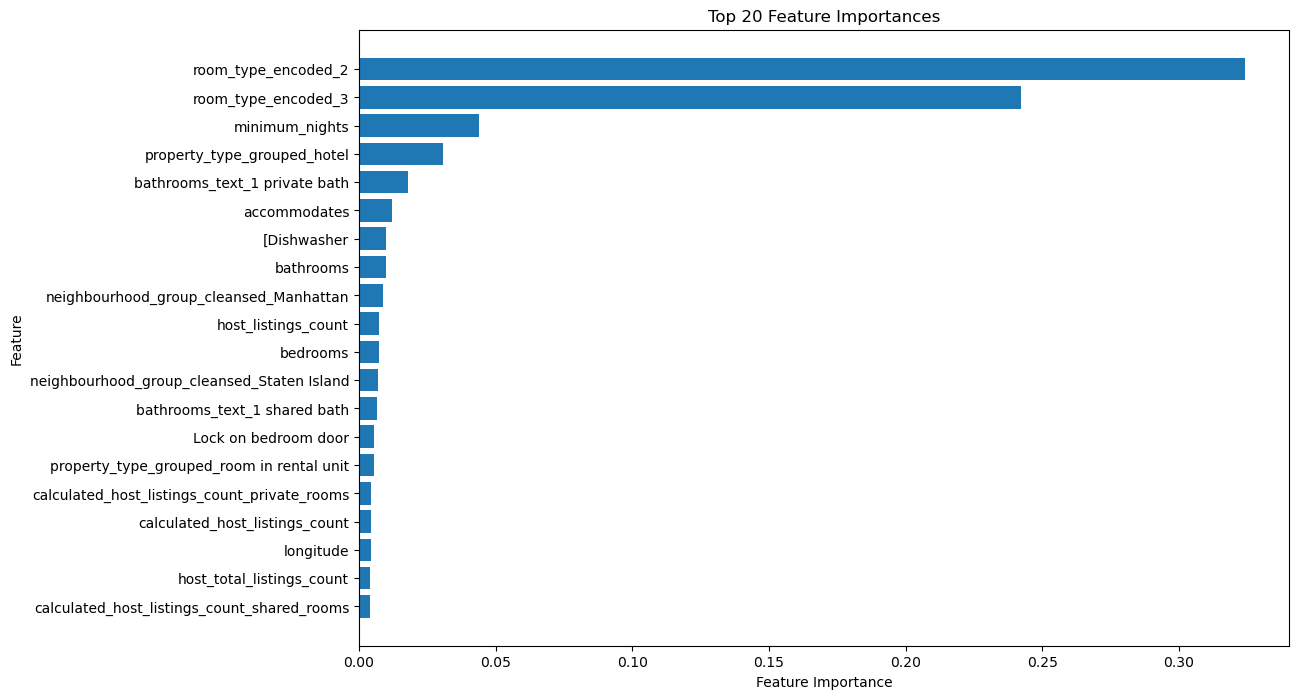

In [ ]:
import matplotlib.pyplot as plt

# Plot the top 20 most important features
top_n = 20  # Number of top features to display
top_features = feature_importance_df.head(top_n)

plt.figure(figsize=(12, 8))
plt.barh(y=top_features['Feature'][::-1], width=top_features['Importance'][::-1])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title(f'Top {top_n} Feature Importances')
plt.show()

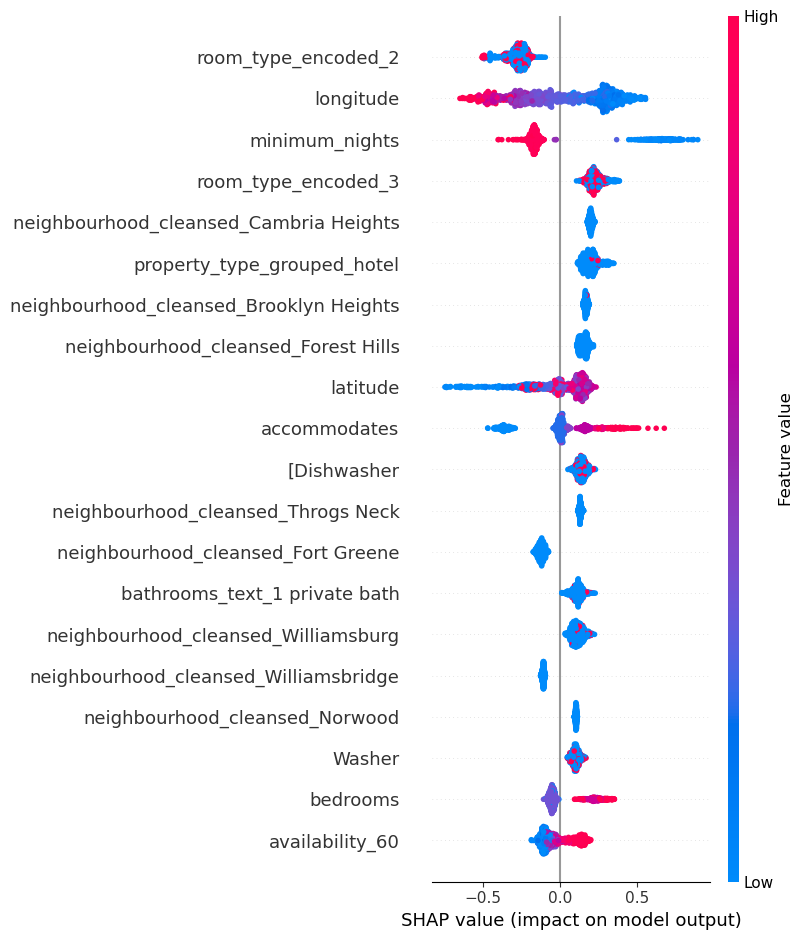

In [ ]:
import shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Prepare a sample from the training data
X_train_sample = X_train.sample(n=1000, random_state=0)  # Adjust n as needed

# Apply the FeatureEngineer transformation
X_train_fe = pipeline.named_steps['feature_engineer'].transform(X_train_sample)

# Apply the preprocessor transformation
X_train_transformed = pipeline.named_steps['preprocessor'].transform(X_train_fe)

# Make X_train_transformed a non-sparse array
X_train_transformed = X_train_transformed.toarray()

# Retrieve feature names
def get_feature_names(preprocessor):
    feature_names = []

    for name, transformer, columns in preprocessor.transformers_:
        if name != 'remainder':
            if isinstance(transformer, Pipeline):
                # Get the last transformer in the pipeline
                transformer = transformer.steps[-1][1]
            if hasattr(transformer, 'get_feature_names_out'):
                # For transformers that provide get_feature_names_out
                try:
                    names = transformer.get_feature_names_out(columns)
                except:
                    # For older versions or transformers without get_feature_names_out
                    names = transformer.get_feature_names()
            else:
                # If get_feature_names_out is not available
                names = columns
            feature_names.extend(names)
        elif transformer == 'passthrough':
            # Append passthrough features
            feature_names.extend(columns)
    return feature_names

# Get feature names
preprocessor = pipeline.named_steps['preprocessor']
feature_names = get_feature_names(preprocessor)

# Create a DataFrame of the transformed features
X_transformed_df = pd.DataFrame(X_train_transformed, columns=feature_names)

# Get the trained model
model = pipeline.named_steps['model']

# Initialize the SHAP TreeExplainer
explainer = shap.TreeExplainer(model)

# Calculate SHAP values
shap_values = explainer.shap_values(X_train_transformed)

# Plot the SHAP summary
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_transformed_df)

In [ ]:
# -- SHAP Value Interpretation --
# how many shap importance values are greater than 0.01
n_features = (np.abs(shap_values).mean(0) > 0.05).sum()
print(f'Number of features with |SHAP| > 0.01: {n_features}')

Number of features with |SHAP| > 0.01: 47


In [ ]:
# ---- Hyperparameter Tuning ----
# Define the parameter search space with improved ranges
param_space = {
    'model__n_estimators': Integer(200, 2000),
    'model__max_depth': Integer(2, 15),
    'model__learning_rate': Real(0.005, 0.4, prior='log-uniform'),
    'model__subsample': Real(0.6, 1.0, prior='uniform'),
    'model__colsample_bytree': Real(0.6, 1.0, prior='uniform'),
    'model__min_child_weight': Integer(1, 10),
    'model__gamma': Real(0.0, 0.5, prior='uniform'),
    'model__reg_alpha': Real(0.0, 1.0, prior='uniform'),
    'model__reg_lambda': Real(0.0, 1.0, prior='uniform'),
}

# Update the model in the pipeline to include early stopping
xgb_model = XGBRegressor(
    objective='reg:squarederror',
    eval_metric='rmse',
    n_jobs=-1,
    random_state=0
)

pipeline.steps[-1] = ('model', xgb_model)  # Replace the model in the pipeline

# Initialize Bayesian search with improvements
bayes_search = BayesSearchCV(
    estimator=pipeline,
    search_spaces=param_space,
    n_iter=50,           # Increased iterations for better exploration
    cv=3,                # Reduced to 3-fold CV for speed
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    random_state=0,
    verbose=0,           # Increased verbosity for monitoring
    refit=True,          # Refit the best model on the whole dataset at the end
)

# Fit the Bayesian search
bayes_search.fit(X, y)

# Best parameters
print("Best Parameters:")
print(bayes_search.best_params_)

# Best CV score
best_rmse = -bayes_search.best_score_
print(f'Best CV RMSE: {best_rmse:.4f}')

/Users/michaelscutari/micromamba/envs/cs671/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/michaelscutari/micromamba/envs/cs671/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/michaelscutari/micromamba/envs/cs671/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/michaelscutari/micromamba/envs/cs671/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all 

Best Parameters:
OrderedDict({'model__colsample_bytree': 0.7896615860728206, 'model__gamma': 0.0, 'model__learning_rate': 0.02157373365594319, 'model__max_depth': 8, 'model__min_child_weight': 10, 'model__n_estimators': 1617, 'model__reg_alpha': 0.0, 'model__reg_lambda': 0.0, 'model__subsample': 0.6})
Best CV RMSE: 0.7260


In [ ]:
# ---- Exporting test results ----
test_df = pd.read_csv('./data/test.csv')

# predict
y_test_pred = pipeline.predict(test_df)

# round to nearest integer
y_test_pred = np.round(y_test_pred, 0).astype(int)

# save to csv
test_df['price'] = y_test_pred
test_df[['id', 'price']].to_csv('./data/test_results.csv', index=False)

Validation RMSE: 0.2542451498226507
